In [3]:
import os
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
from PIL import Image
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from lime import lime_image
import numpy as np
from skimage.segmentation import mark_boundaries
%matplotlib inline

In [4]:
data_dir = "../input/plant disease regonition"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
diseases = os.listdir(train_dir)
print(diseases)
print(len(diseases))

['Healthy', 'Powdery', 'Rust']
3


In [5]:
PATH = './plant3_Res18_full.pth'
model = torch.load(PATH)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
def predict_image(img, model):
    xb = img.unsqueeze(0).cuda()
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return train.classes[preds[0].item()]

In [7]:
transform= transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
batch_size = 64
train = ImageFolder(train_dir, transform=transform)
valid = ImageFolder(valid_dir, transform=transform) 
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=0, pin_memory=True)

In [8]:
test_dir = data_dir + "/test"
test = ImageFolder(test_dir, transform=transform)
test_images = sorted(os.listdir(test_dir+"/test"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
C:\Users\Yueqiao\anaconda3\envs\ttorch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Label: Healthy (1).jpg , Predicted: Healthy


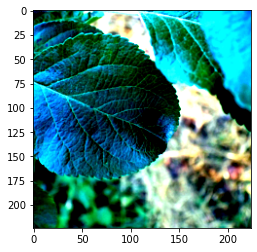

In [9]:
img, label = test[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_images[0], ', Predicted:', predict_image(img, model))

In [10]:
for i, (img, label) in enumerate(test):
    print('Label:', test_images[i], ', Predicted:', predict_image(img, model), i)

Label: Healthy (1).jpg , Predicted: Healthy 0
Label: Healthy (10).jpg , Predicted: Healthy 1
Label: Healthy (11).jpg , Predicted: Healthy 2
Label: Healthy (12).jpg , Predicted: Healthy 3
Label: Healthy (13).jpg , Predicted: Healthy 4
Label: Healthy (14).jpg , Predicted: Healthy 5
Label: Healthy (15).jpg , Predicted: Healthy 6
Label: Healthy (16).jpg , Predicted: Healthy 7
Label: Healthy (17).jpg , Predicted: Healthy 8
Label: Healthy (18).jpg , Predicted: Healthy 9
Label: Healthy (19).jpg , Predicted: Healthy 10
Label: Healthy (2).jpg , Predicted: Healthy 11
Label: Healthy (20).jpg , Predicted: Healthy 12
Label: Healthy (3).jpg , Predicted: Healthy 13
Label: Healthy (4).jpg , Predicted: Healthy 14
Label: Healthy (5).jpg , Predicted: Healthy 15
Label: Healthy (6).jpg , Predicted: Healthy 16
Label: Healthy (7).jpg , Predicted: Healthy 17
Label: Healthy (8).jpg , Predicted: Healthy 18
Label: Healthy (9).jpg , Predicted: Healthy 19
Label: Powdery (1).jpg , Predicted: Powdery 20
Label: Powde

In [11]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 

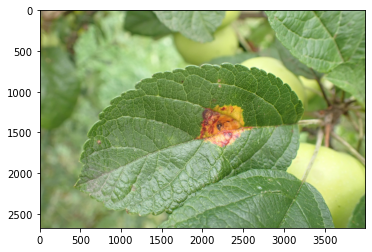

In [61]:
img = get_image(data_dir+'/test/test/Rust (17).JPG')
plt.imshow(img)

  0%|          | 0/1000 [00:00<?, ?it/s]

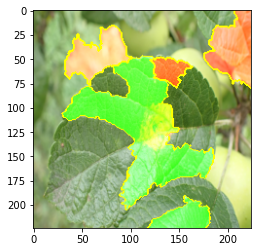

In [62]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

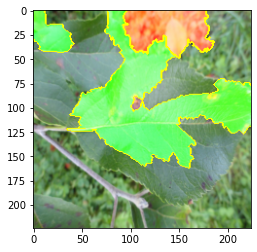

In [13]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

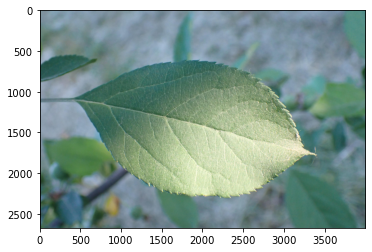

In [14]:
img = get_image(data_dir+'/test/test/Healthy (4).JPG')
plt.imshow(img)

In [15]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

0

In [16]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

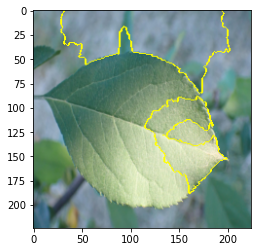

In [17]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

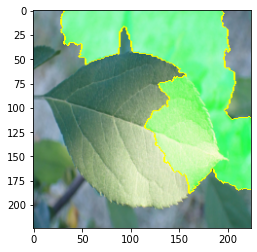

In [18]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

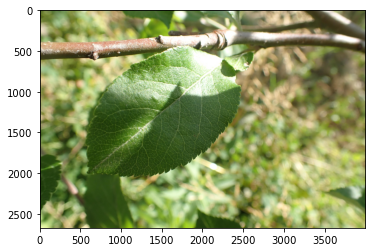

In [19]:
img = get_image(data_dir+'/test/test/Healthy (16).JPG')
plt.imshow(img)

In [20]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

0

In [21]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict,
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

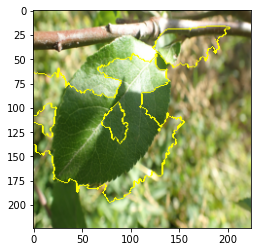

In [22]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

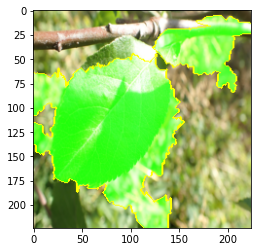

In [23]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

MemoryError: Unable to allocate 30.6 MiB for an array with shape (2672, 4000, 3) and data type bool

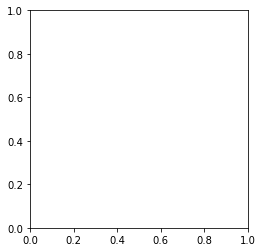

In [24]:
img = get_image(data_dir+'/test/test/Powdery (19).JPG')
plt.imshow(img)

In [ ]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)